In [74]:
import os
import glob
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt

from pprint import pprint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split

from smartcar.utils.path import get_data_paths
from smartcar.utils.read import read_json_label

In [61]:
data_dir = "C:\Projects\SmartCar\data"
image_fnames, label_fnames = get_data_paths(data_dir)

batch_size = 16

In [62]:
class SmartCarGenerator(Sequence):
    def __init__(self, image_fnames, label_fnames, batch_size, image_shape, shuffle=True):
        self.image_fnames = np.array(image_fnames)
        self.label_fnames = np.array(label_fnames)
        self.batch_size = batch_size
        self.image_shape = image_shape
    
        if shuffle:
            indices = np.array([i for i in range(len(image_fnames))])
            indices = np.random.permutation(indices)
            self.image_fnames = self.image_fnames[indices]
            self.label_fnames = self.label_fnames[indices]
        
    def __len__(self):
        return np.ceil(len(self.image_fnames) / float(self.batch_size)).astype(np.int)
                       
    def __getitem__(self, idx):
        x_fnames = self.image_fnames[idx * self.batch_size:(idx+1) * self.batch_size]
        y_fnames = self.label_fnames[idx * self.batch_size:(idx+1) * self.batch_size]
        
        batch_x = np.array([
            cv2.resize(cv2.imread(path), (self.image_shape[1], self.image_shape[0]), interpolation=cv2.INTER_NEAREST) / 255. for path in x_fnames
        ])
        batch_y = np.array([read_json_label(path) for path in y_fnames])
        return batch_x, batch_y

In [63]:
X_train, X_test, y_train, y_test = train_test_split(image_fnames, label_fnames, train_size=0.80, random_state=42)

In [64]:
datagen_train = SmartCarGenerator(X_train, y_train, batch_size=16, image_shape=(120, 160, 3), shuffle=True)
datagen_test = SmartCarGenerator(X_test, y_test, batch_size=16, image_shape=(120, 160, 3), shuffle=True)

In [65]:
def CustomCNN(dropout=0.1):
    img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='linear')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(dropout)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='linear')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(dropout)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    #angle_out = Dense(1, activation='linear', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
    
    #continous output of throttle
    out = Dense(2, activation='linear', name='out')(x)
    model = Model(inputs=[img_in], outputs=[out])
    return model

In [77]:
model = CustomCNN()
                           
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss={'out' : 'mean_squared_error'})

In [78]:
model_path = os.path.abspath("models/test.h5")
checkpointer = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')
hist = model.fit_generator(generator=datagen_train,
                           validation_data=datagen_test,
                           epochs=10,
                           shuffle=True,
                           callbacks=[checkpointer])

Epoch 1/10
248/248 [==============================] - 26s 106ms/step - loss: 102.8775 - val_loss: 0.0877
Epoch 2/10
248/248 [==============================] - 25s 101ms/step - loss: 0.1013 - val_loss: 0.0832
Epoch 3/10
248/248 [==============================] - 25s 102ms/step - loss: 0.1012 - val_loss: 0.0954
Epoch 4/10
248/248 [==============================] - 25s 103ms/step - loss: 0.1013 - val_loss: 0.0817
Epoch 5/10
248/248 [==============================] - 25s 102ms/step - loss: 0.1012 - val_loss: 0.0864
Epoch 6/10
248/248 [==============================] - 25s 101ms/step - loss: 0.1012 - val_loss: 0.0915
Epoch 7/10
248/248 [==============================] - 25s 100ms/step - loss: 0.1001 - val_loss: 0.0803
Epoch 8/10
248/248 [==============================] - 25s 101ms/step - loss: 0.1003 - val_loss: 0.0867
Epoch 9/10
248/248 [==============================] - 25s 101ms/step - loss: 0.0998 - val_loss: 0.0799
Epoch 10/10
248/248 [==============================] - 25s 100ms/step -

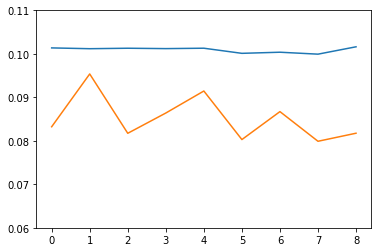

In [92]:
plt.plot(hist.history["loss"][1:])
plt.plot(hist.history["val_loss"][1:])
ax = plt.gca()
ax.set_ylim([0.06, 0.11])
plt.savefig('loss.jpg')